📥 Loading annotations...
🔄 Building dataset...
⚠ Skipping file C:/Users/karti/Downloads/EEG_images/zenodo\eeg1.edf due to error: 
⚠ Skipping file C:/Users/karti/Downloads/EEG_images/zenodo\eeg25.edf due to error: 
⚠ Skipping file C:/Users/karti/Downloads/EEG_images/zenodo\eeg62.edf due to error: 

✅ Dataset shape: (38297, 64)

📊 Original label distribution: [28787  3045  6465]
✅ After SMOTE label distribution: [28787 28787 28787]

📈 Training Report
              precision    recall  f1-score   support

 Non-Seizure       1.00      1.00      1.00     20727
 Pre-Seizure       1.00      1.00      1.00     20726
     Seizure       1.00      1.00      1.00     20726

    accuracy                           1.00     62179
   macro avg       1.00      1.00      1.00     62179
weighted avg       1.00      1.00      1.00     62179


✅ Validation Report
              precision    recall  f1-score   support

 Non-Seizure       0.94      0.92      0.93      5181
 Pre-Seizure       0.93      0.95   

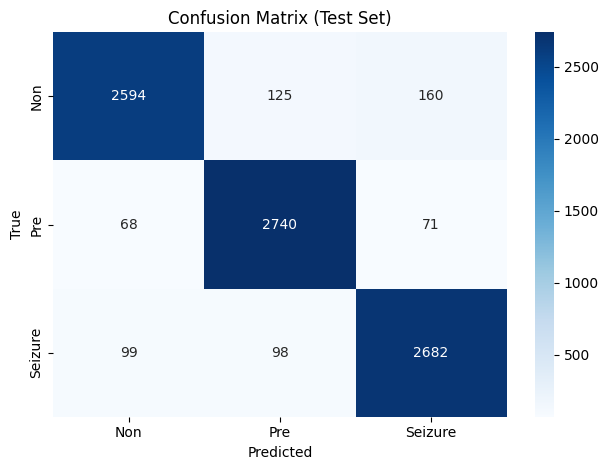

In [3]:
import os
import numpy as np
import mne
import scipy.io
import joblib
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import pywt
from scipy.signal import welch
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore", category=RuntimeWarning)

# ---------- Annotation parsing ----------
def load_annotations(annotation_path):
    mat = scipy.io.loadmat(annotation_path)
    raw_annots = mat["annotat_new"][0]
    seizure_map = {}
    for i, annot in enumerate(raw_annots):
        if annot.shape[0] < 2:
            continue
        edf_name = f"eeg{i+1}.edf"
        mask = annot[1].flatten()
        intervals = extract_intervals(mask)
        seizure_map[edf_name] = intervals
    return seizure_map

def extract_intervals(mask_row):
    intervals = []
    in_seizure = False
    start = 0
    for i, val in enumerate(mask_row):
        if val == 1 and not in_seizure:
            start = i
            in_seizure = True
        elif val == 0 and in_seizure:
            intervals.append((start * 10, i * 10))  # convert window index to seconds
            in_seizure = False
    if in_seizure:
        intervals.append((start * 10, len(mask_row) * 10))
    return intervals

# ---------- Channel extraction ----------
def extract_channels(file_path, channels=[0, 1, 2, 3]):
    try:
        raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)
        data = raw.get_data(picks=channels)
        fs = int(raw.info['sfreq'])
        return data, fs
    except Exception as e:
        print(f"⚠ Skipping file {file_path} due to error: {e}")
        return None, None

# ---------- Feature extraction ----------
def extract_features(signal, fs=256):
    feats = []
    for ch in signal:
        # Time domain
        mean_val = np.mean(ch)
        std_val = np.std(ch)
        min_val = np.min(ch)
        max_val = np.max(ch)
        q25 = np.percentile(ch, 25)
        q75 = np.percentile(ch, 75)

        # Frequency domain (Welch PSD)
        freqs, psd = welch(ch, fs=fs)
        band_power = lambda fmin, fmax: np.sum(psd[(freqs >= fmin) & (freqs < fmax)])
        delta = band_power(0.5, 4)
        theta = band_power(4, 8)
        alpha = band_power(8, 13)
        beta = band_power(13, 30)
        gamma = band_power(30, 45)

        # Entropy
        hist, _ = np.histogram(ch, bins=50, density=True)
        hist += 1e-12
        shannon = -np.sum(hist * np.log2(hist))

        # Wavelet energy
        coeffs = pywt.wavedec(ch, 'db4', level=3)
        wavelet_energies = [np.sum(np.square(c)) for c in coeffs]

        feats.extend([
            mean_val, std_val, min_val, max_val, q25, q75,
            delta, theta, alpha, beta, gamma,
            shannon, *wavelet_energies
        ])
    return feats

# ---------- Segment + Label ----------
def segment_and_label(data, seizure_intervals, fs, window_sec=10, preseizure_margin_sec=900):
    window_size = fs * window_sec
    total_windows = data.shape[1] // window_size
    X, y = [], []

    for i in range(total_windows):
        start = i * window_size
        end = start + window_size
        global_time_sec = start // fs

        label = 0
        for sz_start, sz_end in seizure_intervals:
            sz_start_sec = sz_start
            sz_end_sec = sz_end
            pre_start = max(sz_start_sec - preseizure_margin_sec, 0)

            if sz_start_sec <= global_time_sec < sz_end_sec:
                label = 2  # Seizure
                break
            elif pre_start <= global_time_sec < sz_start_sec:
                label = 1  # Pre-seizure
                break

        segment = data[:, start:end]
        if segment.shape[1] == window_size:
            X.append(extract_features(segment, fs))
            y.append(label)

    return np.array(X), np.array(y)

# ---------- Dataset builder ----------
def build_dataset(edf_folder, seizure_map):
    X_all, y_all = [], []
    for edf_file, intervals in seizure_map.items():
        edf_path = os.path.join(edf_folder, edf_file)
        if not os.path.exists(edf_path):
            print(f"❌ Missing file: {edf_path}")
            continue
        data, fs = extract_channels(edf_path)
        if data is None:
            continue
        try:
            X, y = segment_and_label(data, intervals, fs)
            if len(X) > 0:
                X_all.append(X)
                y_all.append(y)
        except Exception as e:
            print(f"❌ Error segmenting {edf_file}: {e}")
    if not X_all:
        return None, None
    return np.concatenate(X_all), np.concatenate(y_all)

# ---------- Training ----------
def train_random_forest(X, y):
    print("\n📊 Original label distribution:", np.bincount(y))

    # Normalize
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Balance
    smote = SMOTE(random_state=42)
    X_res, y_res = smote.fit_resample(X, y)
    print("✅ After SMOTE label distribution:", np.bincount(y_res))

    # Split
    X_trainval, X_test, y_trainval, y_test = train_test_split(X_res, y_res, stratify=y_res, test_size=0.1, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, stratify=y_trainval, test_size=0.2, random_state=42)

    # Train
    clf = RandomForestClassifier(
        n_estimators=500,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        max_features='log2',           # ✅ valid value
        class_weight='balanced',
        random_state=42
    )
    clf.fit(X_train, y_train)

    # Reports
    print("\n📈 Training Report")
    print(classification_report(y_train, clf.predict(X_train), target_names=["Non-Seizure", "Pre-Seizure", "Seizure"]))

    print("\n✅ Validation Report")
    print(classification_report(y_val, clf.predict(X_val), target_names=["Non-Seizure", "Pre-Seizure", "Seizure"]))

    print("\n🧪 Test Report")
    y_test_pred = clf.predict(X_test)
    print(classification_report(y_test, y_test_pred, target_names=["Non-Seizure", "Pre-Seizure", "Seizure"]))



    # Confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Non", "Pre", "Seizure"], yticklabels=["Non", "Pre", "Seizure"])
    plt.title("Confusion Matrix (Test Set)")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

# ---------- Main ----------
if __name__ == "__main__":
    base_folder = "C:/Users/karti/Downloads/EEG_images/zenodo"
    annotation_file = os.path.join(base_folder, "annotations_2017.mat")

    print("📥 Loading annotations...")
    seizure_map = load_annotations(annotation_file)

    print("🔄 Building dataset...")
    X_all, y_all = build_dataset(base_folder, seizure_map)

    if X_all is not None:
        print(f"\n✅ Dataset shape: {X_all.shape}")
        train_random_forest(X_all, y_all)
    else:
        print("❌ No valid data extracted.")

📥 Loading annotations...
🔄 Building dataset...
⚠ Skipping file C:/Users/karti/Downloads/EEG_images/zenodo\eeg1.edf due to error: 
⚠ Skipping file C:/Users/karti/Downloads/EEG_images/zenodo\eeg25.edf due to error: 
⚠ Skipping file C:/Users/karti/Downloads/EEG_images/zenodo\eeg62.edf due to error: 

✅ Dataset shape: (38297, 64)

📊 Original label distribution: [28787  3045  6465]
✅ After SMOTE label distribution: [28787 28787 28787]


c:\Users\karti\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [23:46:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



📈 Training Report
              precision    recall  f1-score   support

 Non-Seizure       0.99      0.98      0.98     20727
 Pre-Seizure       0.98      0.99      0.99     20726
     Seizure       0.98      0.99      0.99     20726

    accuracy                           0.99     62179
   macro avg       0.99      0.99      0.99     62179
weighted avg       0.99      0.99      0.99     62179


✅ Validation Report
              precision    recall  f1-score   support

 Non-Seizure       0.94      0.91      0.92      5181
 Pre-Seizure       0.91      0.95      0.93      5182
     Seizure       0.92      0.92      0.92      5182

    accuracy                           0.92     15545
   macro avg       0.92      0.92      0.92     15545
weighted avg       0.92      0.92      0.92     15545


🧪 Test Report
              precision    recall  f1-score   support

 Non-Seizure       0.94      0.90      0.92      2879
 Pre-Seizure       0.90      0.95      0.92      2879
     Seizure       0

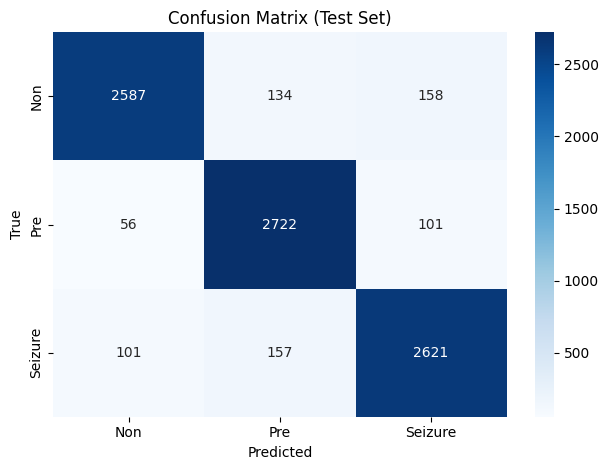

In [16]:
from xgboost import XGBClassifier
import seaborn as sns

# ---------- Training ----------
def train_xgboost(X, y):
    print("\n📊 Original label distribution:", np.bincount(y))

    # Normalize features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Handle class imbalance
    smote = SMOTE(random_state=42)
    X_res, y_res = smote.fit_resample(X, y)
    print("✅ After SMOTE label distribution:", np.bincount(y_res))

    # Train-validation-test split
    X_trainval, X_test, y_trainval, y_test = train_test_split(X_res, y_res, stratify=y_res, test_size=0.1, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, stratify=y_trainval, test_size=0.2, random_state=42)

    # ✅ XGBoost Classifier
    clf = XGBClassifier(
        n_estimators=500,             # Number of boosting rounds
        max_depth=10,                 # Controls tree complexity (try 6–12)
        learning_rate=0.05,           # Lower = more conservative learning
        subsample=0.8,                # Row sampling like RF's bagging
        colsample_bytree=0.8,         # Feature sampling like RF's max_features
        gamma=1,                      # Minimum loss reduction (like RF min_samples_split)
        min_child_weight=5,           # Controls overfitting (like min_samples_leaf)
        reg_alpha=1,                  # L1 regularization (sparse features)
        reg_lambda=1,                 # L2 regularization
        objective='multi:softmax',    # Since you have 3 classes
        num_class=3,                  # For multi-class classification
        eval_metric='mlogloss',       # or 'merror' for accuracy
        use_label_encoder=False,
        random_state=42
    )

    # 🏋️ Train model
    clf.fit(X_train, y_train)

    # Reports
    print("\n📈 Training Report")
    print(classification_report(y_train, clf.predict(X_train), target_names=["Non-Seizure", "Pre-Seizure", "Seizure"]))

    print("\n✅ Validation Report")
    print(classification_report(y_val, clf.predict(X_val), target_names=["Non-Seizure", "Pre-Seizure", "Seizure"]))

    print("\n🧪 Test Report")
    y_test_pred = clf.predict(X_test)
    print(classification_report(y_test, y_test_pred, target_names=["Non-Seizure", "Pre-Seizure", "Seizure"]))


    # Confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Non", "Pre", "Seizure"], yticklabels=["Non", "Pre", "Seizure"])
    plt.title("Confusion Matrix (Test Set)")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

# ---------- Main ----------
if __name__ == "__main__":
    base_folder = "C:/Users/karti/Downloads/EEG_images/zenodo"
    annotation_file = os.path.join(base_folder, "annotations_2017.mat")

    print("📥 Loading annotations...")
    seizure_map = load_annotations(annotation_file)

    print("🔄 Building dataset...")
    X_all, y_all = build_dataset(base_folder, seizure_map)

    if X_all is not None:
        print(f"\n✅ Dataset shape: {X_all.shape}")
        train_xgboost(X_all, y_all)
    else:
        print("❌ No valid data extracted.")

📥 Loading annotations...
🔄 Building dataset...
⚠ Skipping file C:/Users/karti/Downloads/EEG_images/zenodo\eeg1.edf due to error: 
⚠ Skipping file C:/Users/karti/Downloads/EEG_images/zenodo\eeg25.edf due to error: 
⚠ Skipping file C:/Users/karti/Downloads/EEG_images/zenodo\eeg62.edf due to error: 

✅ Dataset shape: (38297, 64)

📊 Original label distribution: [28787  3045  6465]
✅ After SMOTE label distribution: [28787 28787 28787]


c:\Users\karti\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [16:06:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



📈 Training Report
              precision    recall  f1-score   support

 Non-Seizure       1.00      1.00      1.00     20727
 Pre-Seizure       1.00      1.00      1.00     20726
     Seizure       1.00      1.00      1.00     20726

    accuracy                           1.00     62179
   macro avg       1.00      1.00      1.00     62179
weighted avg       1.00      1.00      1.00     62179


✅ Validation Report
              precision    recall  f1-score   support

 Non-Seizure       0.95      0.95      0.95      5181
 Pre-Seizure       0.97      0.97      0.97      5182
     Seizure       0.96      0.96      0.96      5182

    accuracy                           0.96     15545
   macro avg       0.96      0.96      0.96     15545
weighted avg       0.96      0.96      0.96     15545


🧪 Test Report
              precision    recall  f1-score   support

 Non-Seizure       0.95      0.94      0.95      2879
 Pre-Seizure       0.96      0.97      0.96      2879
     Seizure       0

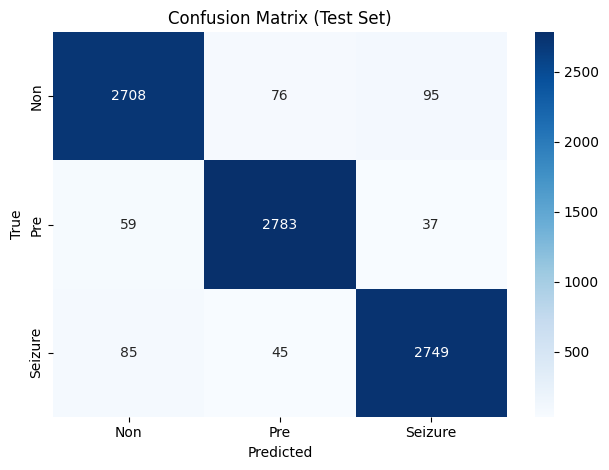

In [4]:
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import os


def train_stacked_model(X, y):
    print("\n📊 Original label distribution:", np.bincount(y))

    # Standardize features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Balance dataset using SMOTE
    smote = SMOTE(random_state=42)
    X_res, y_res = smote.fit_resample(X, y)
    print("✅ After SMOTE label distribution:", np.bincount(y_res))

    # Split dataset
    X_trainval, X_test, y_trainval, y_test = train_test_split(X_res, y_res, stratify=y_res, test_size=0.1, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, stratify=y_trainval, test_size=0.2, random_state=42)

    # Base model 1: Random Forest
    rf = RandomForestClassifier(
        n_estimators=500,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        max_features='log2',
        class_weight='balanced',
        random_state=42
    )

    # Base model 2: XGBoost
    xgb_base = XGBClassifier(
        n_estimators=300,
        max_depth=10,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        gamma=1,
        min_child_weight=5,
        reg_alpha=1,
        reg_lambda=1,
        objective='multi:softmax',
        num_class=3,
        use_label_encoder=False,
        eval_metric='mlogloss',
        random_state=42
    )

    # Meta model: XGBoost
    xgb_meta = XGBClassifier(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='multi:softmax',
        num_class=3,
        use_label_encoder=False,
        eval_metric='mlogloss',
        random_state=42
    )

    # Build stacking classifier
    clf = StackingClassifier(
        estimators=[('rf', rf), ('xgb', xgb_base)],
        final_estimator=xgb_meta,
        passthrough=True,  # include original features
        n_jobs=-1
    )



    # Train model
    clf.fit(X_train, y_train)

    # Reports
    print("\n📈 Training Report")
    print(classification_report(y_train, clf.predict(X_train), target_names=["Non-Seizure", "Pre-Seizure", "Seizure"]))

    print("\n✅ Validation Report")
    print(classification_report(y_val, clf.predict(X_val), target_names=["Non-Seizure", "Pre-Seizure", "Seizure"]))

    print("\n🧪 Test Report")
    y_test_pred = clf.predict(X_test)
    print(classification_report(y_test, y_test_pred, target_names=["Non-Seizure", "Pre-Seizure", "Seizure"]))


    # Confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Non", "Pre", "Seizure"], yticklabels=["Non", "Pre", "Seizure"])
    plt.title("Confusion Matrix (Test Set)")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

# ---------- Main ----------
if __name__ == "__main__":
    base_folder = "C:/Users/karti/Downloads/EEG_images/zenodo"
    annotation_file = os.path.join(base_folder, "annotations_2017.mat")

    print("📥 Loading annotations...")
    seizure_map = load_annotations(annotation_file)

    print("🔄 Building dataset...")
    X_all, y_all = build_dataset(base_folder, seizure_map)

    if X_all is not None:
        print(f"\n✅ Dataset shape: {X_all.shape}")
        train_stacked_model(X_all, y_all)
    else:
        print("❌ No valid data extracted.")

📥 Loading annotations...
🔄 Building dataset...
⚠ Skipping file C:/Users/karti/Downloads/EEG_images/zenodo\eeg1.edf due to error: 
⚠ Skipping file C:/Users/karti/Downloads/EEG_images/zenodo\eeg25.edf due to error: 
⚠ Skipping file C:/Users/karti/Downloads/EEG_images/zenodo\eeg62.edf due to error: 

✅ Dataset shape: (38297, 64)

📊 Original label distribution: [28787  3045  6465]
✅ After SMOTE label distribution: [28787 28787 28787]


c:\Users\karti\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [17:07:54] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



📈 Training Report
              precision    recall  f1-score   support

 Non-Seizure       1.00      1.00      1.00     20727
 Pre-Seizure       1.00      1.00      1.00     20726
     Seizure       1.00      1.00      1.00     20726

    accuracy                           1.00     62179
   macro avg       1.00      1.00      1.00     62179
weighted avg       1.00      1.00      1.00     62179


✅ Validation Report
              precision    recall  f1-score   support

 Non-Seizure       0.95      0.95      0.95      5181
 Pre-Seizure       0.96      0.96      0.96      5182
     Seizure       0.95      0.94      0.95      5182

    accuracy                           0.95     15545
   macro avg       0.95      0.95      0.95     15545
weighted avg       0.95      0.95      0.95     15545


🧪 Test Report
              precision    recall  f1-score   support

 Non-Seizure       0.95      0.94      0.95      2879
 Pre-Seizure       0.96      0.97      0.96      2879
     Seizure       0

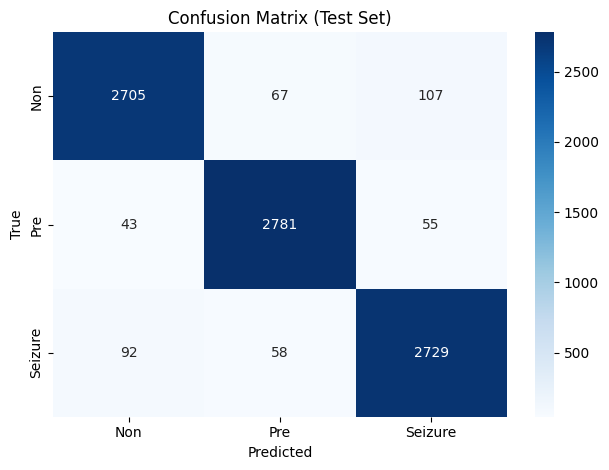

In [7]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

def train_stacked_rf_lgbm(X, y):
    print("\n📊 Original label distribution:", np.bincount(y))

    # ⚖️ Balance dataset using SMOTE
    smote = SMOTE(random_state=42)
    X_res, y_res = smote.fit_resample(X, y)
    print("✅ After SMOTE label distribution:", np.bincount(y_res))

    # 🔀 Split data
    X_trainval, X_test, y_trainval, y_test = train_test_split(
        X_res, y_res, stratify=y_res, test_size=0.1, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(
        X_trainval, y_trainval, stratify=y_trainval, test_size=0.2, random_state=42)

    # 🧼 Feature Scaling
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    # 🌲 Base model 1: Random Forest
    rf = RandomForestClassifier(
        n_estimators=500,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        max_features='log2',
        class_weight='balanced',
        random_state=42
    )

    # 🌿 Base model 2: LightGBM
    lgbm = LGBMClassifier(
        n_estimators=500,         # align with RF
        learning_rate=0.03,       # more conservative for better generalization
        max_depth=15,             # closer to RF's unbounded trees
        num_leaves=50,            # more expressive leaves
        subsample=0.8,
        colsample_bytree=0.8,
        class_weight='balanced',
        random_state=42
    )

    # 🚀 Meta model: XGBoost
    xgb_meta = XGBClassifier(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='multi:softmax',
        num_class=3,
        use_label_encoder=False,
        eval_metric='mlogloss',
        random_state=42
    )

    # 🧠 Stacking
    clf = StackingClassifier(
        estimators=[('rf', rf), ('lgbm', lgbm)],
        final_estimator=xgb_meta,
        passthrough=True,  # includes original features
        n_jobs=-1
    )

    clf.fit(X_train, y_train)

    # Reports
    print("\n📈 Training Report")
    print(classification_report(y_train, clf.predict(X_train), target_names=["Non-Seizure", "Pre-Seizure", "Seizure"]))

    print("\n✅ Validation Report")
    print(classification_report(y_val, clf.predict(X_val), target_names=["Non-Seizure", "Pre-Seizure", "Seizure"]))

    print("\n🧪 Test Report")
    y_test_pred = clf.predict(X_test)
    print(classification_report(y_test, y_test_pred, target_names=["Non-Seizure", "Pre-Seizure", "Seizure"]))


    # Confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Non", "Pre", "Seizure"], yticklabels=["Non", "Pre", "Seizure"])
    plt.title("Confusion Matrix (Test Set)")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

# ---------- Main ----------
if __name__ == "__main__":
    base_folder = "C:/Users/karti/Downloads/EEG_images/zenodo"
    annotation_file = os.path.join(base_folder, "annotations_2017.mat")

    print("📥 Loading annotations...")
    seizure_map = load_annotations(annotation_file)

    print("🔄 Building dataset...")
    X_all, y_all = build_dataset(base_folder, seizure_map)

    if X_all is not None:
        print(f"\n✅ Dataset shape: {X_all.shape}")
        train_stacked_rf_lgbm(X_all, y_all)
    else:
        print("❌ No valid data extracted.")


📥 Loading annotations...
🔄 Building dataset...
⚠ Skipping file C:/Users/karti/Downloads/EEG_images/zenodo\eeg1.edf due to error: 
⚠ Skipping file C:/Users/karti/Downloads/EEG_images/zenodo\eeg25.edf due to error: 
⚠ Skipping file C:/Users/karti/Downloads/EEG_images/zenodo\eeg62.edf due to error: 

✅ Dataset shape: (38297, 64)

🔄 Original label distribution: [28787  3045  6465]
✅ After SMOTE label distribution: [28787 28787 28787]

📈 Training Report
              precision    recall  f1-score   support

 Non-Seizure       1.00      1.00      1.00     20727
 Pre-Seizure       1.00      1.00      1.00     20726
     Seizure       1.00      1.00      1.00     20726

    accuracy                           1.00     62179
   macro avg       1.00      1.00      1.00     62179
weighted avg       1.00      1.00      1.00     62179


✅ Validation Report
              precision    recall  f1-score   support

 Non-Seizure       0.95      0.96      0.96      5181
 Pre-Seizure       0.97      0.98   

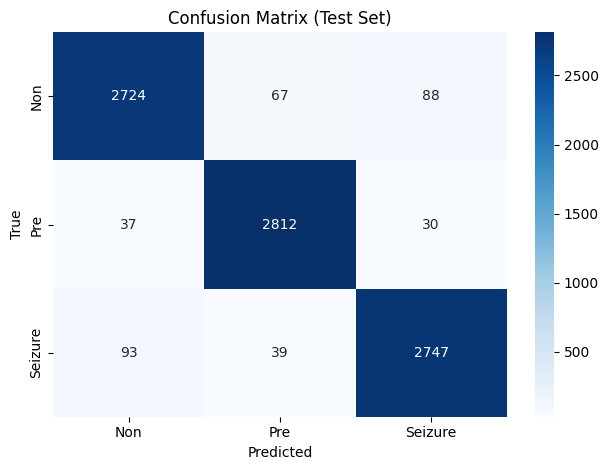

In [9]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

def train_stacked_rf_xgb_lgbm(X, y):
    print("\n🔄 Original label distribution:", np.bincount(y))

    # ⚖️ Apply SMOTE
    smote = SMOTE(random_state=42)
    X_res, y_res = smote.fit_resample(X, y)
    print("✅ After SMOTE label distribution:", np.bincount(y_res))

    # 🔀 Split into train, validation, test sets
    X_trainval, X_test, y_trainval, y_test = train_test_split(X_res, y_res, stratify=y_res, test_size=0.1, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, stratify=y_trainval, test_size=0.2, random_state=42)

    # 🌲 Random Forest
    rf = RandomForestClassifier(
        n_estimators=500,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        max_features='log2',
        class_weight='balanced',
        random_state=42
    )

    # ⚡ XGBoost
    xgb = XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=10,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=1,
        objective='multi:softprob',
        num_class=3,
        random_state=42,
        verbosity=0
    )

    # 🌱 LightGBM
    lgbm = LGBMClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=10,
        num_leaves=31,
        subsample=0.8,
        colsample_bytree=0.8,
        class_weight='balanced',
        random_state=42
    )

    # 🧠 Meta model: XGBoost
    xgb_meta = XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='multi:softprob',
        num_class=3,
        random_state=42,
        verbosity=0
    )

    # 🔗 Stacking
    clf = StackingClassifier(
        estimators=[('rf', rf), ('xgb', xgb), ('lgbm', lgbm)],
        final_estimator=xgb_meta,
        cv=5,
        n_jobs=-1,
        passthrough=True
    )

    # 🏋️ Fit
    clf.fit(X_train, y_train)

    # Reports
    print("\n📈 Training Report")
    print(classification_report(y_train, clf.predict(X_train), target_names=["Non-Seizure", "Pre-Seizure", "Seizure"]))

    print("\n✅ Validation Report")
    print(classification_report(y_val, clf.predict(X_val), target_names=["Non-Seizure", "Pre-Seizure", "Seizure"]))

    print("\n🧪 Test Report")
    y_test_pred = clf.predict(X_test)
    print(classification_report(y_test, y_test_pred, target_names=["Non-Seizure", "Pre-Seizure", "Seizure"]))


    # Confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Non", "Pre", "Seizure"], yticklabels=["Non", "Pre", "Seizure"])
    plt.title("Confusion Matrix (Test Set)")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

# ---------- Main ----------
if __name__ == "__main__":
    base_folder = "C:/Users/karti/Downloads/EEG_images/zenodo"
    annotation_file = os.path.join(base_folder, "annotations_2017.mat")

    print("📥 Loading annotations...")
    seizure_map = load_annotations(annotation_file)

    print("🔄 Building dataset...")
    X_all, y_all = build_dataset(base_folder, seizure_map)

    if X_all is not None:
        print(f"\n✅ Dataset shape: {X_all.shape}")
        train_stacked_rf_xgb_lgbm(X_all, y_all)
    else:
        print("❌ No valid data extracted.")


📥 Loading annotations...
🔄 Building dataset...
⚠ Skipping file C:/Users/karti/Downloads/EEG_images/zenodo\eeg1.edf due to error: 
⚠ Skipping file C:/Users/karti/Downloads/EEG_images/zenodo\eeg25.edf due to error: 
⚠ Skipping file C:/Users/karti/Downloads/EEG_images/zenodo\eeg62.edf due to error: 

✅ Dataset shape: (38297, 64)

🔄 Original label distribution: [28787  3045  6465]
✅ After SMOTE label distribution: [28787 28787 28787]

📈 Training Report
              precision    recall  f1-score   support

 Non-Seizure       1.00      1.00      1.00     20727
 Pre-Seizure       1.00      1.00      1.00     20726
     Seizure       1.00      1.00      1.00     20726

    accuracy                           1.00     62179
   macro avg       1.00      1.00      1.00     62179
weighted avg       1.00      1.00      1.00     62179


✅ Validation Report
              precision    recall  f1-score   support

 Non-Seizure       0.87      0.78      0.82      5181
 Pre-Seizure       0.91      0.93   

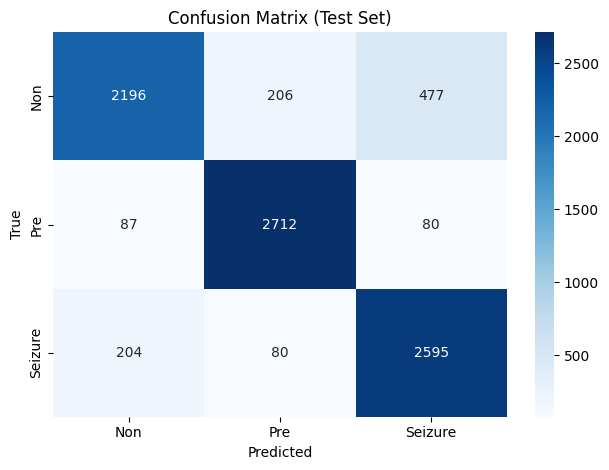

In [12]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import numpy as np

def train_bagging_dt(X, y):
    print("\n🔄 Original label distribution:", np.bincount(y))

    # ⚖️ Apply SMOTE
    smote = SMOTE(random_state=42)
    X_res, y_res = smote.fit_resample(X, y)
    print("✅ After SMOTE label distribution:", np.bincount(y_res))

    # 🔀 Train/Validation/Test Split
    X_trainval, X_test, y_trainval, y_test = train_test_split(X_res, y_res, stratify=y_res, test_size=0.1, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, stratify=y_trainval, test_size=0.2, random_state=42)

    # 🌳 Base Estimator: Decision Tree
    base_dt = DecisionTreeClassifier(
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        random_state=42
    )

    # 🧠 Bagging Ensemble
    clf = BaggingClassifier(
        estimator=base_dt,           # 👈 updated parameter name
        n_estimators=100,
        max_samples=1.0,
        max_features=1.0,
        bootstrap=True,
        n_jobs=-1,
        random_state=42
    )

    # 🏋️ Fit the model
    clf.fit(X_train, y_train)

    # Reports
    print("\n📈 Training Report")
    print(classification_report(y_train, clf.predict(X_train), target_names=["Non-Seizure", "Pre-Seizure", "Seizure"]))

    print("\n✅ Validation Report")
    print(classification_report(y_val, clf.predict(X_val), target_names=["Non-Seizure", "Pre-Seizure", "Seizure"]))

    print("\n🧪 Test Report")
    y_test_pred = clf.predict(X_test)
    print(classification_report(y_test, y_test_pred, target_names=["Non-Seizure", "Pre-Seizure", "Seizure"]))


    # Confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Non", "Pre", "Seizure"], yticklabels=["Non", "Pre", "Seizure"])
    plt.title("Confusion Matrix (Test Set)")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

# ---------- Main ----------
if __name__ == "__main__":
    base_folder = "C:/Users/karti/Downloads/EEG_images/zenodo"
    annotation_file = os.path.join(base_folder, "annotations_2017.mat")

    print("📥 Loading annotations...")
    seizure_map = load_annotations(annotation_file)

    print("🔄 Building dataset...")
    X_all, y_all = build_dataset(base_folder, seizure_map)

    if X_all is not None:
        print(f"\n✅ Dataset shape: {X_all.shape}")
        train_bagging_dt(X_all, y_all)
    else:
        print("❌ No valid data extracted.")
